In [1]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt



In [2]:
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch



preprocessed_data = pd.read_csv("/Users/ahmedalkhulayfi/Documents/Stanford/Labs/project/preprocessed_data.csv")

# Step 1: Prepare features and labels
X = preprocessed_data.drop(columns=["Target_encoded"]).values  # Features
y = preprocessed_data["Target_encoded"].values  # Labels

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert features and labels to PyTorch tensors
node_features = torch.tensor(X_scaled, dtype=torch.float)
node_labels = torch.tensor(y, dtype=torch.long)


# Identify the source columns
source_cols = [col for col in preprocessed_data.columns if col.startswith("Source_")]

edges = []
for i in range(len(preprocessed_data)):
    # Extract the source pattern for node i
    source_i = preprocessed_data.iloc[i][source_cols].values
    cip_i = preprocessed_data.iloc[i]["Target_encoded"]
    
    # The argmax will give the index of the '1' in the one-hot encoding
    source_i_idx = source_i.argmax()

    for j in range(i + 1, len(preprocessed_data)):
        source_j = preprocessed_data.iloc[j][source_cols].values
        cip_j = preprocessed_data.iloc[j]["Target_encoded"]
        source_j_idx = source_j.argmax()

        # Check same source and CIP equality
        if source_i_idx == source_j_idx and cip_i == cip_j:
            edges.append((i, j))

            
# Step 3: Create the PyTorch Geometric Data object
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
print("edge_index shape:", edge_index.shape)
print("edge_index dtype:", edge_index.dtype)
print(node_features.shape)
data = Data(x=node_features, edge_index=edge_index, y=node_labels)
print(edges)

# preprocessed_data["CIP_numeric"]

edge_index shape: torch.Size([2, 3343])
edge_index dtype: torch.int64
torch.Size([261, 28])
[(0, 1), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 26), (0, 27), (0, 34), (0, 47), (0, 48), (0, 49), (0, 50), (0, 52), (0, 63), (0, 64), (0, 65), (0, 66), (0, 68), (0, 70), (0, 72), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 124), (0, 125), (0, 126), (0, 251), (0, 252), (0, 253), (0, 254), (0, 255), (0, 256), (0, 257), (0, 258), (0, 259), (0, 260), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 26), (1, 27), (1, 34), (1, 47), (1, 48), (1, 49), (1, 50), (1, 52), (1, 63), (1, 64), (1, 65), (1, 66), (1, 68), (1, 70), (1, 72), (1, 79), (1, 80), (1, 81), (1, 82), (1, 83), (1, 124), (1, 125), (1, 126), (1, 251), (1, 252), (1, 253), (1, 254), (1, 255), (1, 256), (1, 257), (1, 258), (1, 259), (1, 260), (2, 25), (2, 55), (2, 73), (2, 74), (2, 75), (2, 76), (2, 77), (2, 78), (2, 85), 

In [3]:
preprocessed_data.columns

Index(['Sample_FC', 'Sample_FCS', 'Sample_FFC', 'Sample_PC', 'Source_A',
       'Source_B', 'Source_C', 'Source_D', 'Source_E', 'Source_F', 'Source_H',
       'Source_I', 'Source_J', 'Source_K', 'Source_L', 'Source_M', 'Source_N',
       'Source_O', 'Source_P', 'Source_Q', 'Source_Unknown', 'AMI_symbol_I',
       'AMI_symbol_S', 'AMP_numeric', 'AMP_special_case', 'AMP_symbol_R',
       'AMP_symbol_S', 'CIP_numeric', 'Target_encoded'],
      dtype='object')

In [4]:
# Define train/test/val masks
torch.manual_seed(4)
num_nodes = data.num_nodes
train_ratio, val_ratio, test_ratio = 0.7, 0.1, 0.2

# Randomly shuffle nodes
indices = torch.randperm(num_nodes)
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

# Add masks to the data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # Node features and edges
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Log-softmax for classification

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# Hyperparameters
input_dim = data.num_node_features
hidden_dim = 16
output_dim = len(torch.unique(data.y))
learning_rate = 0.01
weight_decay = 5e-4
max_epochs = 1000
patience = 50

model = GCN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Add LR Cosine Annealing
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

criterion = torch.nn.CrossEntropyLoss()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[mask], data.y[mask])
        preds = out[mask].argmax(dim=1)
        accuracy = (preds == data.y[mask]).sum().item() / mask.sum().item()
    return loss.item(), accuracy

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    # Step the scheduler after optimizer step
    scheduler.step()

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, data, data.val_mask)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    if epoch % 10 == 0:
        train_preds = out[data.train_mask].argmax(dim=1)
        train_accuracy = (train_preds == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
        current_lr = scheduler.get_last_lr()[0]
        print(
            f"Epoch: {epoch}, LR: {current_lr:.6f}, "
            f"Train Loss: {train_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
        )

# Load the best model state
model.load_state_dict(best_model_state)


Epoch: 0, LR: 0.010000, Train Loss: 2.2227, Train Acc: 0.4066, Val Loss: 2.0755, Val Acc: 0.3846
Epoch: 10, LR: 0.009997, Train Loss: 0.5990, Train Acc: 0.7857, Val Loss: 0.5897, Val Acc: 0.8462
Epoch: 20, LR: 0.009989, Train Loss: 0.3936, Train Acc: 0.8297, Val Loss: 0.4350, Val Acc: 0.8462
Epoch: 30, LR: 0.009976, Train Loss: 0.3353, Train Acc: 0.8956, Val Loss: 0.4460, Val Acc: 0.8462
Epoch: 40, LR: 0.009959, Train Loss: 0.2904, Train Acc: 0.9011, Val Loss: 0.4530, Val Acc: 0.8462
Epoch: 50, LR: 0.009936, Train Loss: 0.2469, Train Acc: 0.9231, Val Loss: 0.4045, Val Acc: 0.8462
Epoch: 60, LR: 0.009908, Train Loss: 0.2093, Train Acc: 0.9451, Val Loss: 0.3774, Val Acc: 0.8462
Epoch: 70, LR: 0.009876, Train Loss: 0.1770, Train Acc: 0.9615, Val Loss: 0.3539, Val Acc: 0.8462
Epoch: 80, LR: 0.009839, Train Loss: 0.1482, Train Acc: 0.9615, Val Loss: 0.3188, Val Acc: 0.8846
Epoch: 90, LR: 0.009797, Train Loss: 0.1227, Train Acc: 0.9615, Val Loss: 0.2937, Val Acc: 0.8846
Epoch: 100, LR: 0.009

<All keys matched successfully>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.96      0.96      0.96        26
           2       0.83      1.00      0.91         5

    accuracy                           0.96        53
   macro avg       0.93      0.97      0.95        53
weighted avg       0.97      0.96      0.96        53

Confusion Matrix:
 [[21  1  0]
 [ 0 25  1]
 [ 0  0  5]]


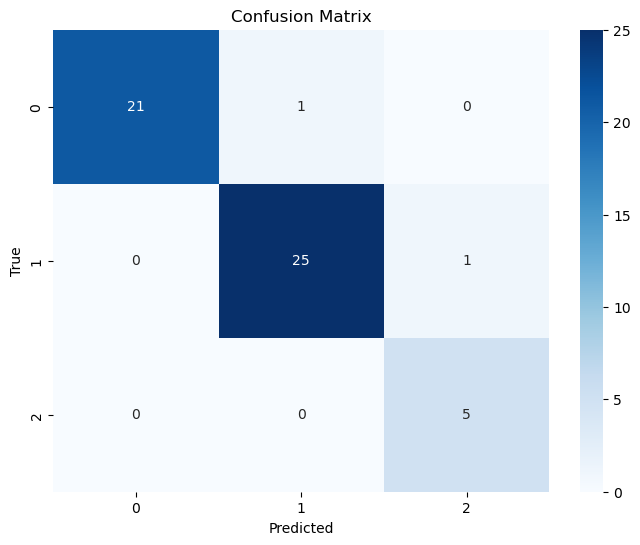

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data)  # Forward pass
    test_preds = out[data.test_mask].argmax(dim=1).cpu().numpy()  # Predicted labels
    test_labels = data.y[data.test_mask].cpu().numpy()  # True labels

    # Classification report
    report = classification_report(test_labels, test_preds, target_names=[str(i) for i in range(output_dim)])
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(output_dim)], yticklabels=[str(i) for i in range(output_dim)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

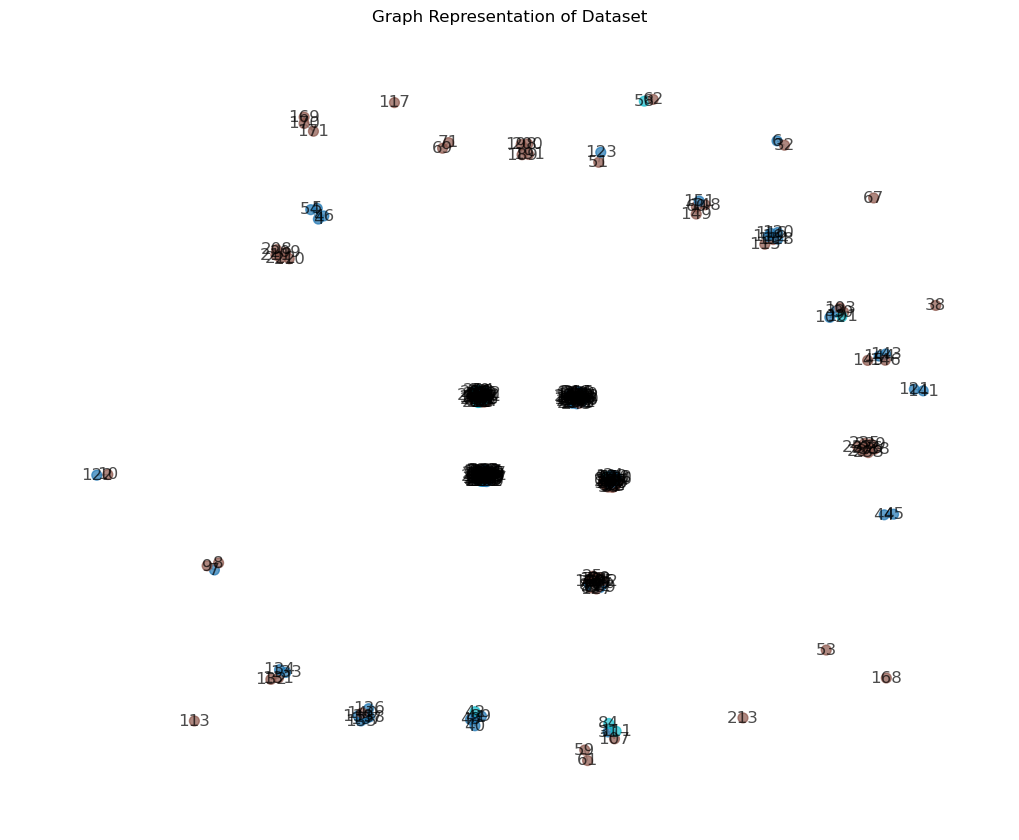

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert PyTorch Geometric data to NetworkX
G = nx.Graph()
edge_index = data.edge_index.numpy()  # Convert edges to NumPy array
G.add_edges_from(edge_index.T)  # Add edges
G.add_nodes_from(range(data.num_nodes))  # Add nodes

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Generate layout
nx.draw(
    G,
    pos,
    node_color=data.y.numpy(),  # Use labels to color nodes
    cmap=plt.cm.tab10,  # Color map for distinct classes
    with_labels=True,
    node_size=50,
    edge_color="gray",
    alpha=0.7
)
plt.title("Graph Representation of Dataset")
plt.show()